In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import json
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from keras.layers import LeakyReLU
from keras import backend as K
import librosa
import keras
import glob
import random
# import speech_recognition as sr

# DATA_PATH = "/content/drive/My Drive/json/train_v7.json"
DATA_PATH = "/content/drive/MyDrive/json/fillter_strong.json"


In [73]:
#@title Default title text
def load_data(data_path):
    with open(data_path, "r",encoding="utf-8") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    # print(X.shape)
    # X_re = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    # sc = MinMaxScaler(feature_range=(0, 1))
    # X_re_sc = sc.fit_transform(X_re)
    # X = X_re_sc.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    
    
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.Conv2D(64, (3,3) ,activation='relu'))
    # model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.3))
    # model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.25))

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu')) # 原為64
    model.add(keras.layers.Dense(32, activation="relu"))
    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [74]:
#@title Default title text
from tensorflow.keras.optimizers import SGD
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)


# create network
input_shape = (X_train.shape[1], X_train.shape[2],1)
print(input_shape)
model = build_model(input_shape)

# compile model
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0003, #0.0002
    decay_steps=25,
    decay_rate=0.9)
optimiser = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

(79, 13, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 77, 11, 128)       1280      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 9, 64)         73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 5, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 5, 64)         256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 3, 64)         36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 2, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 2,

In [75]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_validation.shape)
print(y_validation.shape)

(487, 79, 13, 1)
(487,)
(203, 79, 13, 1)
(203,)
(122, 79, 13, 1)
(122,)


In [76]:
# train model
K.set_learning_phase(0)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=2)
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=500, callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 0s 30ms/step - loss: 0.7086 - accuracy: 0.5339 - val_loss: 0.7297 - val_accuracy: 0.4918
Epoch 2/500
8/8 [==============================] - 0s 13ms/step - loss: 0.6714 - accuracy: 0.5893 - val_loss: 0.7171 - val_accuracy: 0.5000
Epoch 3/500
8/8 [==============================] - 0s 12ms/step - loss: 0.6634 - accuracy: 0.6283 - val_loss: 0.6748 - val_accuracy: 0.5492
Epoch 4/500
8/8 [==============================] - 0s 11ms/step - loss: 0.6106 - accuracy: 0.6776 - val_loss: 0.6237 - val_accuracy: 0.6311
Epoch 5/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5631 - accuracy: 0.7536 - val_loss: 0.5453 - val_accuracy: 0.7049
Epoch 6/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5338 - accuracy: 0.7556 - val_loss: 0.5322 - val_accuracy: 0.6885
Epoch 7/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5175 - accuracy: 0.7454 - val_loss: 0.4880 - val_accuracy: 0.7787
Epoch 8/500
8/8 [===

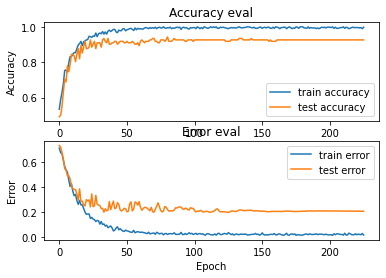

In [77]:
plot_history(history)

In [78]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)


# pick a sample to predict from the test set
X_to_predict = X_test[10]
y_to_predict = y_test[10]

# predict sample
predict(model, X_to_predict, y_to_predict)

7/7 - 0s - loss: 0.2046 - accuracy: 0.9163

Test accuracy: 0.9162561297416687
Target: 0, Predicted label: [0]


In [79]:
pre = model.predict_classes(X_test)
num = len(pre)
diff = 0
for n in range(num):
    if y_test[n] != pre[n]:
        diff+=1
result = (1-(diff/num))*100
print(result, '%')

91.62561576354679 %


Text(0.5, 0, 'Predicted label')

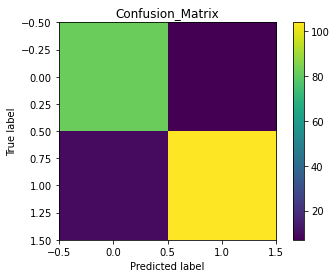

In [80]:
# 混淆矩陣
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, pre)
plt.imshow(CM, interpolation='nearest')    # 在特定的窗口上显示图像
plt.title("Confusion_Matrix")    # 图像标题
plt.colorbar()
plt.ylabel('True label')    
plt.xlabel('Predicted label')

In [81]:
# 儲存權重
from keras.models import load_model
# model.save('./drive/My Drive/model/'+'New: '+ str(round(test_loss,4)) + " - " +str(round(test_acc,4)) + '.h5')
# 載入
model_load = load_model("/content/drive/MyDrive/model/New: 0.341 - 0.9212.h5")

In [82]:
def load_data_test(data_path):
    with open(data_path, "r",encoding="utf-8") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

In [83]:
TEST_PATH = "test_1130.json"
# TEST_PATH = "/content/drive/MyDrive/json/test_1.json"

X, y = load_data_test(TEST_PATH)
X = X[..., np.newaxis]
X = X[:,np.newaxis]
X.shape

FileNotFoundError: ignored

In [ ]:
input = (X.shape[1],X.shape[2],1)
input

In [ ]:
level1=0
level2=0
level3=0
level4=0
level5=0

def score_(point):
  global level1, level2, level3, level4, level5
  if point >=0 and point <=20:
    level1+=1
    return ('你的美式口音還需要多加強')
  elif point >=21 and point <=40:
    level2+=1
    return ('你的美式口音有抓到一點訣竅，但還有很多細節沒有到位，多多練習')
  elif point >=41 and point <=60:
    level3+=1
    return ('你的美式口音表現很不錯, 但一些口音細節還需要加強')
  elif point >=61 and point <=80:
    level4+=1
    return ('你的美式口音整理表現得很好、細節也有到位, 多練習就完美囉 ')
  elif point >=81 and point <=100:
    level5+=1
    return ('你的美式口英非常標準, 恭喜你')

In [ ]:
name_list=[]
with open(TEST_PATH, mode='r', encoding='utf-8') as fp:
  data = json.load(fp)
  for i, n in enumerate(data['name']):
    # if (i+1)%4==0:
    name_list.append(n)

In [ ]:
# name_list

In [96]:
score_sum=0
name_score=0
point_list=[]
for i, pre in enumerate(X):
    prediction = model_load.predict(pre)
    # print("prediction: ",prediction)
    predictied_index = np.argmax(prediction, axis=1)
    if int(predictied_index[0]) == 0:
      predictied_index = np.argmin(prediction, axis=1)
    score = (prediction[0][predictied_index])
    # # print(i, predictied_index)
    print("prediction: ", prediction)
    # print(i, score)
    score_sum += score
    if (i+1)%4==0:
      print(name_list[name_score],":",(score_sum/4)*100, "正確答案是: ",y[i])
      # print("第",int((i+1)/4),"學生美式口音分數: " ,(score_sum/4)*100, "正確答案是: ",y[i])
      response = int((score_sum/4)*100)
      point_list.append(response)
      print(score_(response))
      score_sum=0
      name_score+=1

ValueError: ignored

In [97]:
statistics={
    'Level1':level1,
    'Level2':level2,
    'Level3':level3,
    'Level4':level4,
    'Level5':level5
}
statistics

NameError: ignored

In [98]:
round(1-(83+35+32)/(428+68),3)

0.698

In [99]:
score_list=[]
for n in statistics.keys():
  score_list.append(statistics[n])

NameError: ignored

In [100]:
import matplotlib.pyplot as plt

AttributeError: ignored

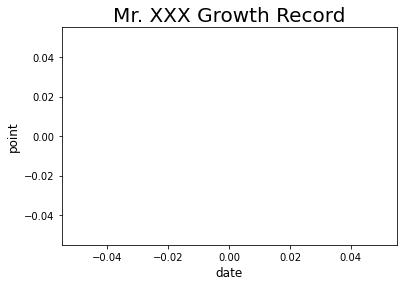

In [101]:
plt.plot(point_list, color="b", linewidth=3)
plt.figsize=(12,8)
plt.title('Mr. XXX Growth Record',fontsize=20)
plt.xlabel('date',fontsize=12)
plt.ylabel('point',fontsize=12)
plt.xtick(fontsize=10)
plt.ytick(fontsize=10)
plt.grid(True)
plt.show()

(558,)


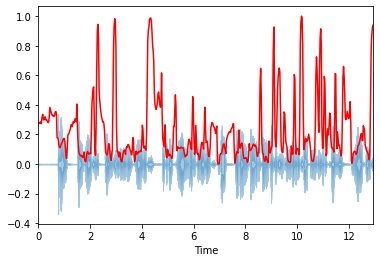

In [102]:
##光譜質心 Spectral Centroid

test_file = "/content/Lily Collins Discusses Filming Tolkien and Ted Bundy Biopic This Morning_11.wav"
x, sr = librosa.load(test_file)
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
print(spectral_centroids.shape)
# (2647,)
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

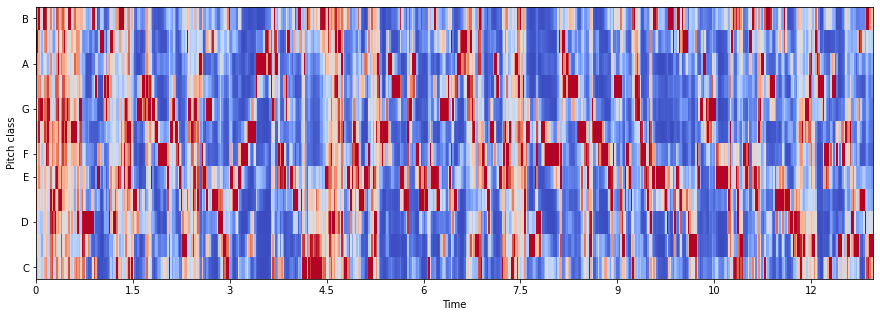

In [103]:
from librosa import display
## 色度頻率
hop_length = 512
chromgram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15,5))
display.specshow(chromgram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

(20, 558)
[-1.40071149e-16  3.82012224e-17  1.14603667e-16  5.09349631e-17
  0.00000000e+00  4.45680927e-17 -6.36687039e-17 -2.22840464e-17
 -3.18343520e-17 -6.36687039e-18 -2.54674816e-17 -1.27337408e-17
  2.54674816e-16 -6.36687039e-18  5.09349631e-17 -1.14603667e-16
 -8.91361855e-17  2.54674816e-17 -1.52804889e-16 -1.01869926e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


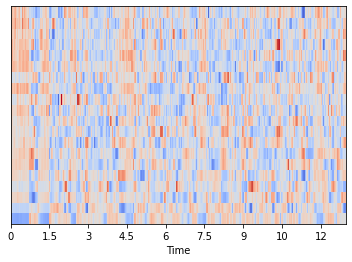

In [104]:
import sklearn
## mfcc應用
mfccs = librosa.feature.mfcc(x, sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

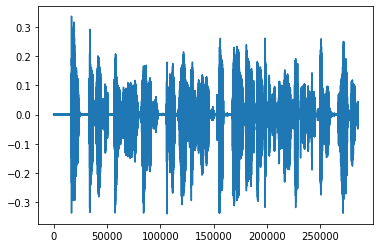

In [105]:
## 原始音檔
plt.plot(x)
plt.show()

DB維度:  (1025, 558)
絕對值平均響度=  29.911622007317945


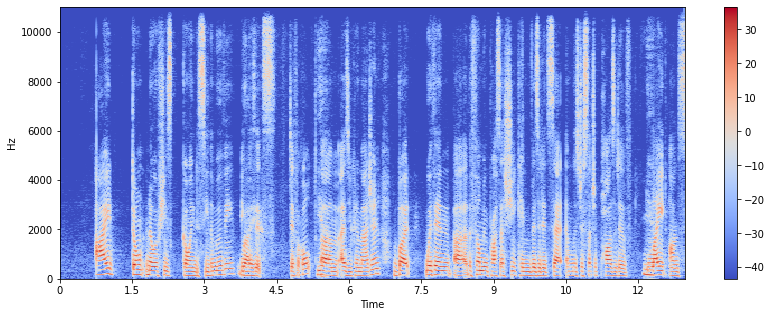

In [106]:
# 短時傅立葉轉換
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
Xdb_sum = 0
print("DB維度: ",Xdb.shape)
for n in Xdb:
  for n1 in n:
    Xdb_sum+=abs(n1)
print("絕對值平均響度= ", (Xdb_sum/(1025*558)))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [107]:
import essentia
import essentia.standard as es

# Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                              rhythmStats=['mean', 'stdev'],
                                              tonalStats=['mean', 'stdev'])(test_file)

print("綜合響度", features['lowlevel.loudness_ebu128.integrated'])
print("平均響度", features['lowlevel.loudness_ebu128.loudness_range'])
print("預估Key:",features['tonal.key_edma.key'], features['tonal.key_edma.scale'])

綜合響度 -23.591005325317383
平均響度 2.312408447265625
預估Key: E major


chroma [[0.23896514 0.24055228 0.24237744 ... 0.25711581 0.25729267 0.25840389]
 [0.24541251 0.24824222 0.25086952 ... 0.2336226  0.23334185 0.23393616]
 [0.29878982 0.29843126 0.29801725 ... 0.43864098 0.44124197 0.44311248]
 ...
 [0.24679783 0.24722164 0.24760861 ... 0.20081835 0.20183872 0.20266214]
 [0.22436166 0.22672535 0.22894498 ... 0.34369348 0.35023261 0.35632232]
 [0.25751752 0.25650675 0.25560068 ... 0.23848085 0.24064139 0.24295627]]


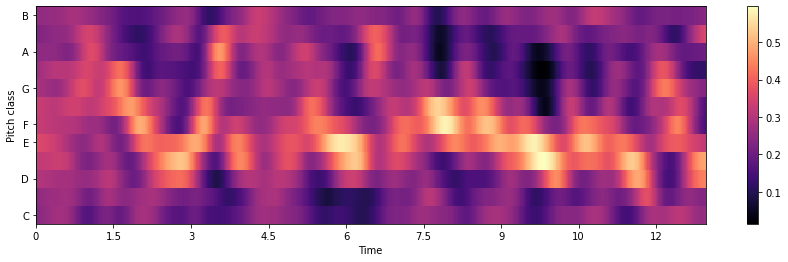

In [108]:
## 色度分布歸一化, 音頻匹配, 相似度任務可用
chroma = librosa.feature.chroma_cens(x, sr=sr)
plt.figure(figsize=(15, 4))
print("chroma", chroma)
librosa.display.specshow(chroma,y_axis='chroma', x_axis='time')
plt.colorbar()

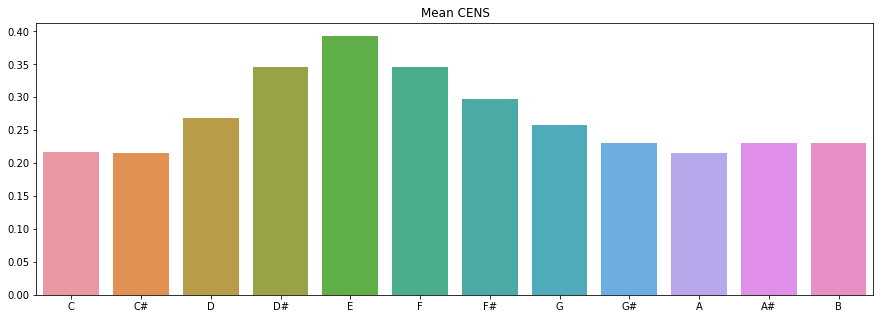

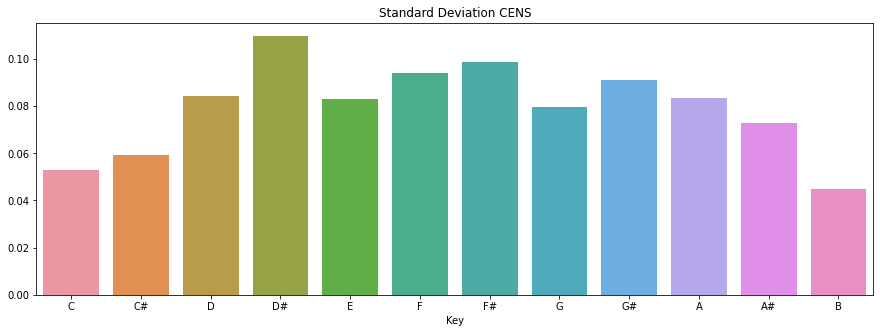

In [109]:
import seaborn as sns

# a pitch histogram using CENS
chroma_mean = np.mean(chroma,axis=1)
chroma_std = np.std(chroma,axis=1)

# plot the summary
octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
plt.figure(figsize = (15,5))
plt.title('Mean CENS')
sns.barplot(x=octave,y=chroma_mean)

plt.figure(figsize = (15,5))
plt.title('Standard Deviation CENS')
plt.xlabel('Key')
plt.ylabel('')
sns.barplot(x=octave,y=chroma_std)

(128, 405)


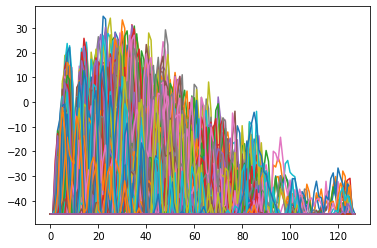

In [110]:
import librosa
## 梅爾倒頻譜MFC Log-Mel Spectrogram ##
## 特徵 - 語音識別和環境聲音識別常使用的特禎 ##
y, sr = librosa.load(test_file, sr=16000)
melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)
logmelspec = librosa.amplitude_to_db(melspec)
print(logmelspec.shape)
plt.plot(logmelspec)
plt.show()